In [1]:
import warnings
warnings.filterwarnings('ignore')

# Configuration de MLFlow avec tracking local

In [2]:
# La version utilisée initialement de mlflow 2.17.0 n'est plus compatible 
# ! pip install mlflow==2.17.0 --use-deprecated=legacy-resolver
import mlflow

In [3]:
# Asignation du serveur de tracking MLFlow
mlflow.set_tracking_uri("http://localhost:5000")
# Création de l'expérimentation "approche classique"
mlflow.set_experiment("approche_classique")

<Experiment: artifact_location='mlflow-artifacts:/374735653194037029', creation_time=1729108772155, experiment_id='374735653194037029', last_update_time=1729108772155, lifecycle_stage='active', name='approche_classique', tags={}>

# Approche classique: embeddings de mots

In [4]:
import pandas as pd

In [5]:
train_df = pd.read_csv("./data/train_df.csv")
test_df = pd.read_csv("./data/test_df.csv")
val_df = pd.read_csv("./data/val_df.csv")

In [6]:
train_df.shape

(3395, 15)

In [7]:
val_df.shape

(1456, 15)

In [8]:
test_df.shape

(1617, 15)

In [9]:
y_train = train_df["target"]
y_test = test_df["target"]
y_val = val_df["target"]

### Embeddings de comptage des mots

En réalisant les embeddings de façon indépendante sur le jeu de train et de test on s'assure qu'il n'y a pas de fuite de données et que l'appréciation de performance du modèle ne sera pas biaisée. Cependant il y a un fort risque d'avoir des OOV lors du test.

In [10]:
train_df .head()

target         ids                          date      flag         user  \
0       0  1977563166  Sat May 30 21:13:33 PDT 2009  NO_QUERY       IamTam   
1       0  2069918369  Sun Jun 07 16:46:09 PDT 2009  NO_QUERY        eyeDu   
2       0  2190833602  Tue Jun 16 03:51:13 PDT 2009  NO_QUERY    prispatel   
3       0  2044695036  Fri Jun 05 09:42:05 PDT 2009  NO_QUERY  KevinDelano   
4       0  1994165464  Mon Jun 01 11:30:57 PDT 2009  NO_QUERY  KellyMcEwen   

                                                text  sentiment_score  \
0  Redboxing it with the crew. The smell of deet ...                4   
1  Just wrapped! shouts to @marcclark and the cre...                4   
2  thinking whether should return Ji Herng his lu...                4   
3    en route to Baltimore airport to pick up Molly                 4   
4  @emmacandlish re-reading new moon. decided im ...                4   

                                        cleaned_text  \
0  Red boxing it with the crew. The smell of DEET...   
1  Just wrapped! Shouts to <mention> and the crew...   
2  Thinking whether you should return Ji Herne hi...   
3    En route to Baltimore airport to pick up Molly    
4  <mention> re-reading new moon. Decided I am ta...   

                                           tokenized  \
0  ['Red', 'boxing', 'it', 'with', 'the', 'crew',...   
1  ['Just', 'wrapped', '!', 'Shouts', 'to', '<men...   
2  ['Thinking', 'whether', 'you', 'should', 'retu...   
3  ['En', 'route', 'to', 'Baltimore', 'airport', ...   
4  ['<mention>', 're-reading', 'new', 'moon', '.'...   

                                   preprocessed_text  \
0  red boxing crew  smell deet going overwhelming...   
1  wrapped ! shout <mention> crew ! shot sum new ...   
2  thinking whether return ji herne luggage  keep...   
3              en route baltimore airport pick molly   
4  <mention> rereading new moon  decided taking c...   

                              preprocessed_tokenized  length_text  \
0  ['red', 'boxing', 'crew', 'smell', 'deet', 'go...           98   
1  ['wrapped', '!', 'shout', '<mention>', 'crew',...          131   
2  ['thinking', 'whether', 'return', 'ji', 'herne...           85   
3  ['en', 'route', 'baltimore', 'airport', 'pick'...           47   
4  ['<mention>', 'rereading', 'new', 'moon', 'dec...          115   

   length_tokenized  length_preprocessed_tokenized  sia_sentiment  
0                21                              8        0.39715  
1                24                             14        0.50000  
2                18                              9        0.50000  
3                 9                              6        0.50000  
4                25                             13        0.22635

#### CountVectorizer

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
train_count_sparse = count_vectorizer.fit_transform(train_df['preprocessed_text'])
val_count_sparse = count_vectorizer.transform(val_df['preprocessed_text'])
test_count_sparse = count_vectorizer.transform(test_df['preprocessed_text'])


In [12]:
# # Précaution à prendre avec les matrices creuses
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler(with_mean=False)
# train_count_scaled = scaler.fit_transform(train_count_sparse)
# test_count_scaled = scaler.fit_transform(test_count_sparse)

In [13]:
# Compactage des matrices creuses
import scipy.sparse
train_count = pd.DataFrame(train_count_sparse.toarray(), columns=count_vectorizer.get_feature_names_out())
val_count = pd.DataFrame(val_count_sparse.toarray(), columns=count_vectorizer.get_feature_names_out())
test_count = pd.DataFrame(test_count_sparse.toarray(), columns=count_vectorizer.get_feature_names_out())

In [14]:
from scipy.sparse import csr_matrix, hstack
train_count["target"] = y_train.values
val_count["target"] = y_val.values
test_count["target"] = y_test.values

### Modélisation à partir des embeddings de mots : test rapides avec Pycaret

In [130]:
# important pycaret supporte python 3.9 à 3.11, attention à utiliser plutôt 3.9 pour éviter les conflits avec MLFlow et Pycaret
import sys
print(sys.version)

3.9.20 (main, Oct  3 2024, 07:38:01) [MSC v.1929 64 bit (AMD64)]


In [16]:
# ! pip install pycaret 3.3.2
# ! pip install pycaret[full]

In [17]:
import pycaret
from pycaret.classification import *

In [20]:
s = setup(
    data=train_count, 
    target='target', 
    test_data=val_count, 
    fold_strategy='stratifiedkfold',
    fold=10,
    session_id=123, 
    index=False, 
    use_gpu=True,
    log_experiment=True, 
    experiment_name="approche_classique", 
    experiment_custom_tags={'framework': 'pycaret', 'vectorizer': 'count vectorizer'}
)


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: gfx1035, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the 

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: gfx1035, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the 

In [21]:
# Vérification de l'expérimentation active
# Afficher l'expérimentation active
print(mlflow.get_experiment_by_name("approche_classique"))

# Afficher le statut du tracking URI (pour confirmer que MLFlow est bien configuré)
print(mlflow.get_tracking_uri())

<Experiment: artifact_location='mlflow-artifacts:/374735653194037029', creation_time=1729108772155, experiment_id='374735653194037029', last_update_time=1729108772155, lifecycle_stage='active', name='approche_classique', tags={}>
http://localhost:5000


In [22]:
# compare baseline models and returns the best 6 ones
best_models = compare_models(sort='Accuracy',n_select=8 ) #, include=["nb", "lr"]

2024/12/06 12:24:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/06 12:24:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression at: http://localhost:5000/#/experiments/374735653194037029/runs/22f672d517dd421e9564d496ed52526b.
2024/12/06 12:24:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/374735653194037029.
2024/12/06 12:24:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/06 12:24:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random Forest Classifier at: http://localhost:5000/#/experiments/374735653194037029/runs/13277c4b97e14bb39a8f24e45348a6cd.
2024/12/06 12:24:37 INFO mlflow.tracking._tracking_service.client:

In [23]:
# Sélection manuelle de modèles pour stacking
rf = best_models[1]  # extra tree 
lr = best_models[0]  # logistic regression 
gbc = best_models[6]  # ridge

In [24]:
# Construire le modèle Stacked avec ces modèles (on peut aussi créer des modèles lr = create_model("lr"))
stacked_model = stack_models([rf, lr, gbc])

2024/12/06 12:52:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/06 12:52:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run Stacking Classifier at: http://localhost:5000/#/experiments/374735653194037029/runs/7e08e91fd1304424aee3c7ec32387fc8.
2024/12/06 12:52:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/374735653194037029.


In [25]:
stacked_model

StackingClassifier(cv=5,
                   estimators=[('Random Forest Classifier',
                                RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='sqrt',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       monotonic_cst=None,
                                                       n_estimators=100...
                                                           validation_fraction=0.1,
                                                           verbose=0,
                                                           warm_start=False))],
                   final_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                      dual=False,
                                                      fit_intercept=True,
                                                      intercept_scaling=1,
                                                      l1_ratio=None,
                                                      max_iter=1000,
                                                      multi_class='auto',
                                                      n_jobs=None, penalty='l2',
                                                      random_state=123,
                                                      solver='lbfgs',
                                                      tol=0.0001, verbose=0,
                                                      warm_start=False),
                   n_jobs=1, passthrough=False, stack_method='auto', verbose=0)

In [26]:
# plot confusion matrix
plot_model(stacked_model, plot = 'confusion_matrix', save=True)

'Confusion Matrix.png'

In [27]:
# Récupérer les runs actifs et identifier celui de "Stacking Classifier"
client = mlflow.tracking.MlflowClient()
experiment_id = client.get_experiment_by_name('approche_classique').experiment_id 
# Lister les runs
runs = client.search_runs(experiment_id, filter_string="tags.mlflow.runName = 'Stacking Classifier'")
# Récupérer le run_id du premier run correspondant
run_id = runs[0].info.run_id

In [28]:
# Générer la matrice de confusion et la sauvegarder localement
plot_model(stacked_model, plot='confusion_matrix', save=True)

# Loguer l'image dans le run existant (nested car il est dans le run parent du setup)
mlflow.start_run(run_id=run_id, nested=True)  # Démarrer sur le run existant
mlflow.log_artifact("Confusion Matrix.png")  # Ajouter l'image comme artéfact
mlflow.end_run()  # Terminer le run

2024/12/06 12:59:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run Stacking Classifier at: http://localhost:5000/#/experiments/374735653194037029/runs/7e08e91fd1304424aee3c7ec32387fc8.
2024/12/06 12:59:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/374735653194037029.


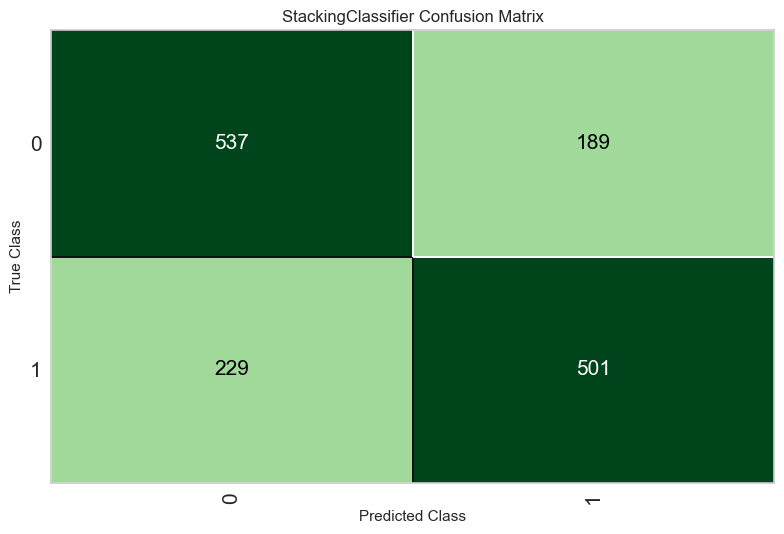

In [29]:
plot_model(stacked_model, plot='confusion_matrix')

Le stacking combine les forces des différents modèles en donnant des performances homogènes.<br>

Pour cet embedding nous allons aussi optimiser le meilleur des modèles. On optimise par rapport à l'accuracy car l'optimisation selon recall conduit à obtenir uniquement la classe 1.
On sauvegarde dans MLFlow un modèle complet avec schéma de données et signature.

In [30]:
import mlflow
from mlflow.models.signature import infer_signature
from pycaret.classification import tune_model, predict_model, plot_model
import pandas as pd

# Démarrer un nouveau run MLflow séparé pour `tuned_model`
with mlflow.start_run(run_name="Best model CountVectorizer", nested=True) as run:
    
    # Effectuer le tuning du modèle
    tuned_model = tune_model(estimator=best_models[0], 
                             optimize="Accuracy", 
                             choose_better=True, 
                             verbose=False)
    
    # Générer des prédictions pour définir la signature et le schéma de données
    pred_holdouts = predict_model(tuned_model, data=test_count)
    input_data = test_count.drop("target", axis=1)  # Données d'entrée sans la colonne cible
    output_data = pred_holdouts  # Données de sortie du modèle
    signature = infer_signature(input_data, output_data)

    # Logger le modèle tuné avec le schéma de données et la signature
    mlflow.sklearn.log_model(
        sk_model=tuned_model, 
        artifact_path="tuned_model",
        signature=signature
    )
    
    # Logger les hyperparamètres et les métriques
    mlflow.log_params(tuned_model.get_params())  # Hyperparamètres
    accuracy = tuned_model.score(test_count.drop("target", axis=1), test_count["target"])
    mlflow.log_metric("Accuracy", accuracy)  

    # Sauvegarder et loguer la matrice de confusion
    plot_model(tuned_model, plot='confusion_matrix', save=True)
    mlflow.log_artifact("Confusion Matrix.png")  # Loguer comme artefact
    
    # Sauvegarder et loguer l'AUC
    plot_model(tuned_model, plot='auc', save=True)
    mlflow.log_artifact("AUC.png")  # Loguer comme artefact
    
    # Sauvegarder et loguer le Boundary plot
    plot_model(tuned_model, plot='boundary', save=True)
    mlflow.log_artifact("Decision Boundary.png")  # Loguer comme artefact

    # Sauvegarder et loguer le classification report
    plot_model(tuned_model, plot='class_report', save=True) 
    mlflow.log_artifact("Class Report.png")  # Loguer comme artefact

    print("Modèle, métriques et artefacts logués avec succès.")


2024/12/06 13:03:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/06 13:03:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression at: http://localhost:5000/#/experiments/374735653194037029/runs/82b6645b63d74fa196ff00168d9fd84f.
2024/12/06 13:03:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/374735653194037029.


2024/12/06 13:03:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run Best model CountVectorizer at: http://localhost:5000/#/experiments/374735653194037029/runs/be1287e6a2694deca124a7b36f0752d2.
2024/12/06 13:03:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/374735653194037029.


Modèle, métriques et artefacts logués avec succès.


In [31]:
tuned_model
# ou plot_model(tuned_model, plot="parameter")

LogisticRegression(C=0.472, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

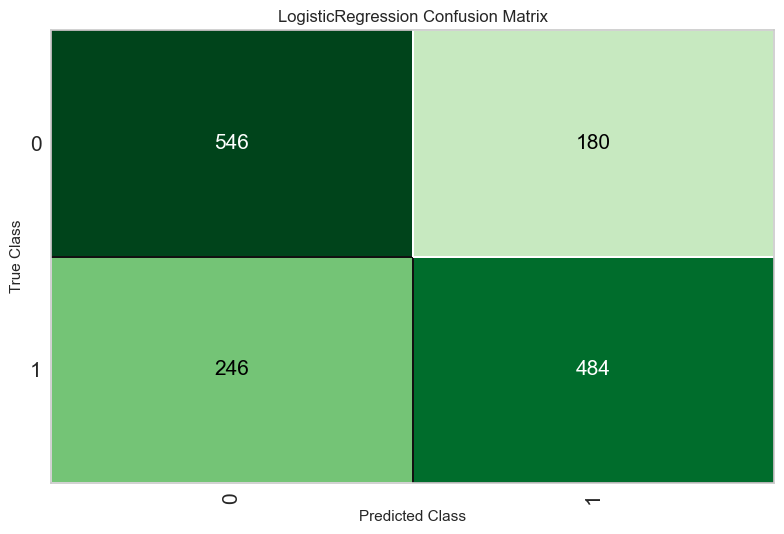

In [32]:
# plot confusion matrix
plot_model(tuned_model, plot = 'confusion_matrix')

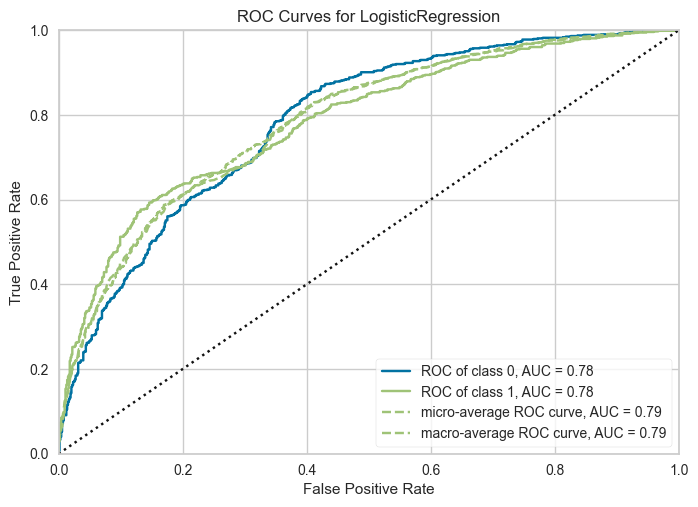

In [33]:
plot_model(tuned_model, plot = 'auc')

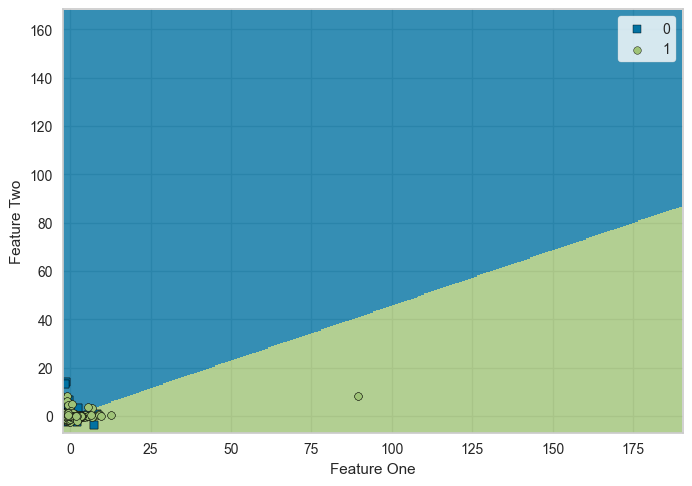

In [34]:
plot_model(tuned_model, plot = 'boundary') # sans normalisation

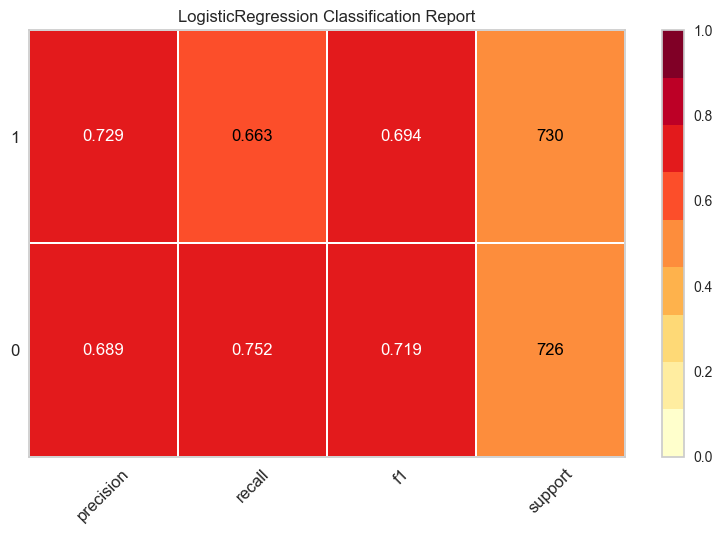

In [35]:
plot_model(tuned_model, plot = 'class_report') 

Le tuning a produit ce que était recherché: un bon recall avec une valeur d'accuary à 0.7. Le modèle tuné finalisé a un temps de calcul de l'ordre de la seconde.

In [36]:
# Finalize the model (train on the entire dataset)
finalize_model(tuned_model)

2024/12/06 13:08:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/06 13:08:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression at: http://localhost:5000/#/experiments/374735653194037029/runs/010c4e17963c4168814ef82e93066a70.
2024/12/06 13:08:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/374735653194037029.


Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['01', '032010', '0415', '0430',
                                             '05', '0530', '0640hr', '09', '10',
                                             '100', '10000', '10010', '100bt',
                                             '100mi', '100mph', '100th',
                                             '101130', '1017', '1022', '1030',
                                             '1030pm', '104', '10411', '1045',
                                             '106', '106npark', '10am',
                                             '10hour', '10hrs', '10pm', ...],
                                    transformer=Simp...
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+'))),
                ('actual_estimator',
                 LogisticRegression(C=0.472, class_weight='balanced',
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=1000, multi_class='auto',
                                    n_jobs=None, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [61]:
import os
from datetime import datetime
from pycaret.classification import save_model

# Définir le chemin du répertoire courant
PATH = os.getcwd() + os.sep

# Créer le sous-répertoire 'models' s'il n'existe pas
models_dir = PATH + "models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Définir l'heure actuelle pour ajouter au nom du modèle
current_time = datetime.now().strftime("%m-%d-%Y_%H-%M")

# Sauvegarder le modèle dans le répertoire 'models'
save_model(tuned_model, os.path.join(models_dir, "best_model_CountVectorizer_" + current_time))

# Charger le modèle sauvegardé
# loaded_bestmodel = load_model(os.path.join(models_dir, 'best_model_CountVectorizer_' + current_time))

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['0430', '09', '10', '10 hour',
                                              '10 min', '100', '100 follower',
                                              '106', '106 flight', '10pm', '11',
                                              '1130', '11pm', '12', '12 crew',
                                              '12 hour', '12 week', '125',
                                              '12hour', '12hour flight', '13',
                                              '13 hour', '130', '14', '15',
                                              '15 min', '15 minute', '17',
                                              '17th', '18', ...],
                                     transformer=...
                  TransformerWrapper(exclude=None, include=None,
                                     transformer=CleanColumnNames

In [37]:
# Générer des prédictions pour le jeu de test (données jamais vues)
predictions = predict_model(tuned_model, data=test_count)

In [38]:
df = predictions

##### Représentation 2D

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


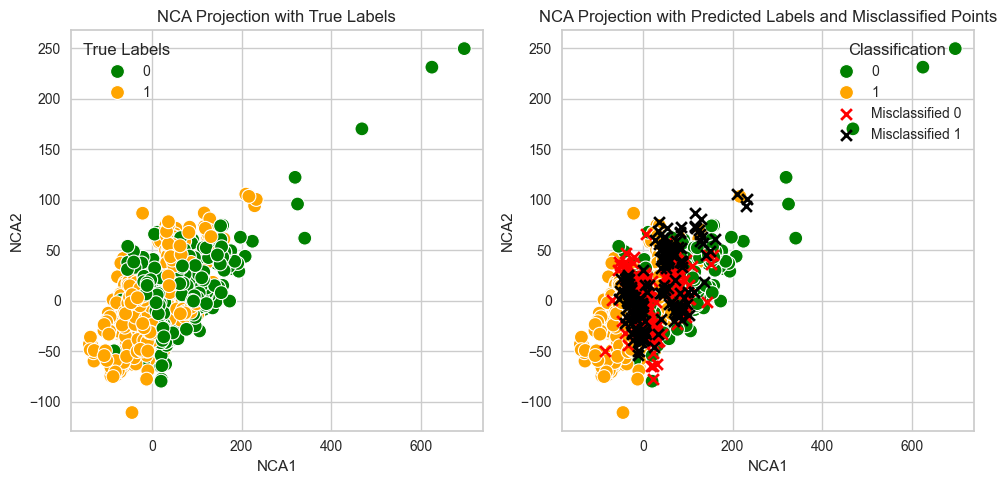


Faux Négatifs (Prédit comme 0, mais vrai label 1) :
- @emmacandlish re-reading new moon. decided im taking eclips on the plane, so i wanna read new moon before it . LOL 
- The airport keeps taking people away from me.  
- Sitting in the airport, just got off the phone with Verizon to have them fix my phone! Will be home soon!!! 
- Just landed in Florida!! Now another flight to puerto rico! But it's two hours long this time 
- Did anyone have issues with their 360 ghostbusters flight suit code not working?  #xbox #ghostbusters
- feels bad for robert being attcked by paps in the airport. also, feels bad for watching these videos. 
- Was listening to @Eminem and @taylorswift13 on the plane 
- I'm sad @kacisloss is leaving today. I should have told her it wasn't possible to change her flight. 
- @BerlyAnne *grins* I am glad to see a smile from you this morning! Packed-n-ready to fly yet?? No rush of course, 6 a.m. flight.. 
- Thanks to the crew of EclecticRadio and Havana for the great ni

In [40]:
! pip install seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NeighborhoodComponentsAnalysis

def visualize_nca_predictions(df, train_df):
    """
    Visualise les prédictions d'un modèle en utilisant Neighborhood Components Analysis (NCA) en 2D.
    
    Paramètres :
    - df : DataFrame contenant les features, les vraies étiquettes ('target'), et les prédictions ('prediction_label').
    - train_df : DataFrame contenant les textes d'origine pour les faux positifs et faux négatifs.
    """
    
    # Séparer les features des labels
    features = df.drop(columns=['target', 'prediction_label', 'prediction_score'])
    true_labels = df['target']
    predicted_labels = df['prediction_label']

    # Appliquer Neighborhood Component Analysis (NCA) pour réduire à 2 dimensions
    nca = NeighborhoodComponentsAnalysis(n_components=2, random_state=42)
    nca_transformed = nca.fit_transform(features, true_labels)

    # Création d'un DataFrame pour la visualisation
    nca_df = pd.DataFrame(nca_transformed, columns=['NCA1', 'NCA2'])
    nca_df['True Labels'] = true_labels
    nca_df['Predicted Labels'] = predicted_labels

    # Identifier les points mal classés
    nca_df['Misclassified'] = nca_df['True Labels'] != nca_df['Predicted Labels']

    # Identifier les faux positifs et les faux négatifs
    nca_df['False Positive'] = (nca_df['True Labels'] == 0) & (nca_df['Predicted Labels'] == 1)
    nca_df['False Negative'] = (nca_df['True Labels'] == 1) & (nca_df['Predicted Labels'] == 0)

    # Retrouver les textes mal interprétés pour les faux positifs et les faux négatifs
    false_positive_texts = train_df.loc[nca_df[nca_df['False Positive']].index, 'text']
    false_negative_texts = train_df.loc[nca_df[nca_df['False Negative']].index, 'text']

    # Créer une figure avec deux sous-graphes
    plt.figure(figsize=(10, 5))
    
    # Graphique 1 : Projection NCA avec les labels réels
    plt.subplot(1, 2, 1)
    sns.scatterplot(x='NCA1', y='NCA2', hue='True Labels', data=nca_df, palette={0: 'green', 1: 'orange'}, s=100)
    plt.title('NCA Projection with True Labels')

    # Graphique 2 : Projection NCA avec les labels prédits et les points mal classés
    plt.subplot(1, 2, 2)

    # Points correctement classés (cercles)
    sns.scatterplot(x='NCA1', y='NCA2', hue='Predicted Labels', data=nca_df[~nca_df['Misclassified']], 
                    palette={0: 'green', 1: 'orange'}, s=100, marker='o')

    # Points mal classés (croix rouges pour 0 et noires pour 1)
    sns.scatterplot(x='NCA1', y='NCA2', data=nca_df[nca_df['False Positive']], 
                    color='red', s=60, marker='x', label='Misclassified 0', edgecolor='red', linewidth=2)
    sns.scatterplot(x='NCA1', y='NCA2', data=nca_df[nca_df['False Negative']], 
                    color='black', s=60, marker='x', label='Misclassified 1', edgecolor='black', linewidth=2)

    plt.title('NCA Projection with Predicted Labels and Misclassified Points')

    # Ajustement de la légende manuellement
    plt.legend(title='Classification', loc='upper right')

    # Afficher les graphes
    plt.tight_layout()
    plt.show()

    # Afficher les textes mal interprétés par groupe
    print("\nFaux Négatifs (Prédit comme 0, mais vrai label 1) :")
    for text in false_negative_texts:
        print(f"- {text}")

    print("\nFaux Positifs (Prédit comme 1, mais vrai label 0) :")
    for text in false_positive_texts:
        print(f"- {text}")

# Exemple d'utilisation
visualize_nca_predictions(df, train_df)


In [41]:
mlflow.end_run()

2024/12/06 13:11:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run Pycaret (CountVectorizer) at: http://localhost:5000/#/experiments/374735653194037029/runs/f704392325a64046b6a09ad4514e26a5.
2024/12/06 13:11:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/374735653194037029.


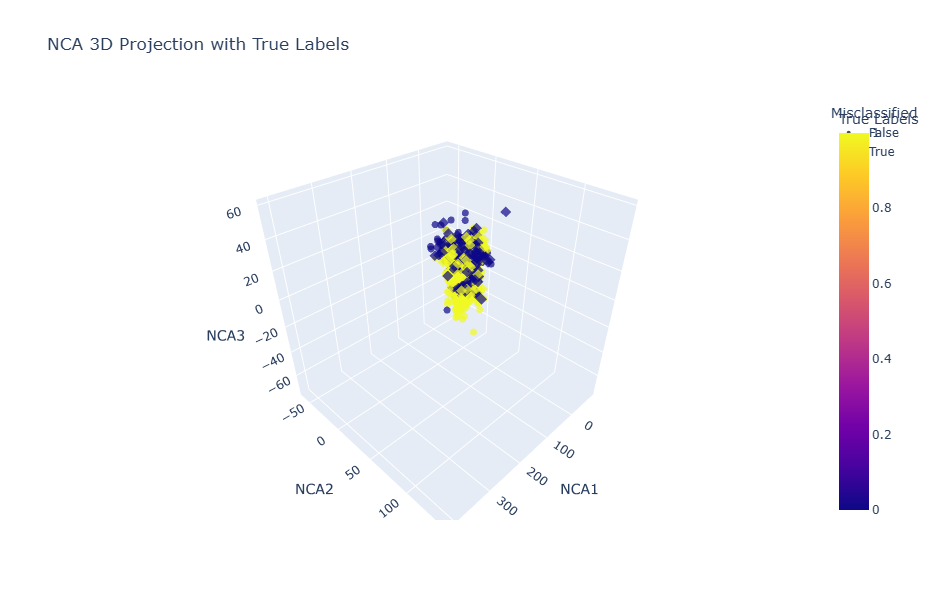

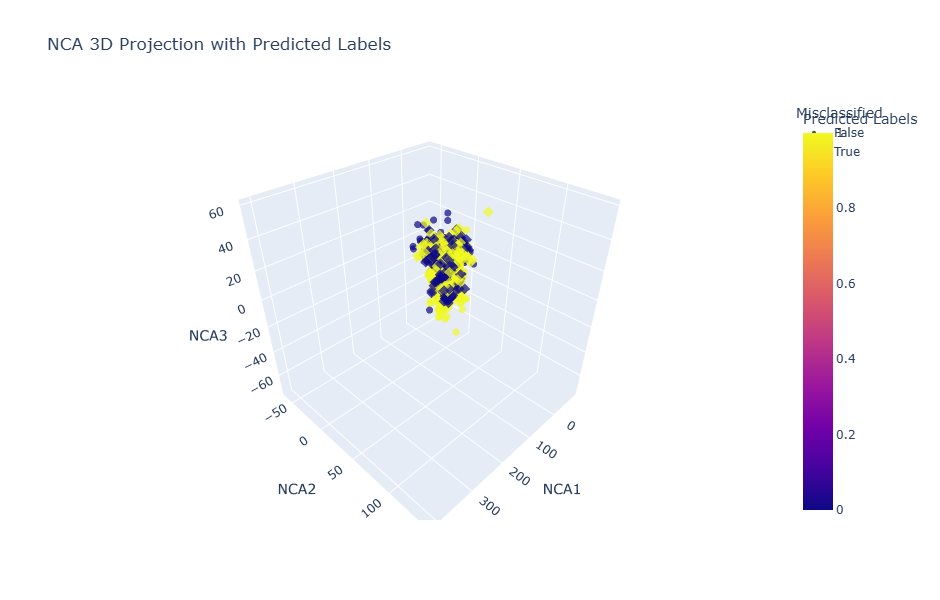

In [42]:
import pandas as pd
import plotly.express as px
from sklearn.neighbors import NeighborhoodComponentsAnalysis

# Séparer les features des labels
features = df.drop(columns=['target', 'prediction_label', 'prediction_score'])
true_labels = df['target']
predicted_labels = df['prediction_label']

# Appliquer Neighborhood Component Analysis (NCA) pour réduire à 3 dimensions
nca = NeighborhoodComponentsAnalysis(n_components=3, random_state=42)
nca_transformed = nca.fit_transform(features, true_labels)

# Création d'un DataFrame pour la visualisation
nca_df = pd.DataFrame(nca_transformed, columns=['NCA1', 'NCA2', 'NCA3'])
nca_df['True Labels'] = true_labels
nca_df['Predicted Labels'] = predicted_labels

# Identifier les points mal classés
nca_df['Misclassified'] = nca_df['True Labels'] != nca_df['Predicted Labels']

# Identifier les faux positifs et les faux négatifs
nca_df['False Positive'] = (nca_df['True Labels'] == 0) & (nca_df['Predicted Labels'] == 1)
nca_df['False Negative'] = (nca_df['True Labels'] == 1) & (nca_df['Predicted Labels'] == 0)

# Retrouver les textes mal interprétés pour les faux positifs et les faux négatifs
false_positive_texts = train_df.loc[nca_df[nca_df['False Positive']].index, 'text']
false_negative_texts = train_df.loc[nca_df[nca_df['False Negative']].index, 'text']

# Ajustements de la taille du graphe et des marqueurs
marker_size = 4  # Taille des marqueurs plus petite
figure_size = (800, 600)  # Taille du graphe ajustée

# Graphique 3D interactif avec les labels réels
fig1 = px.scatter_3d(nca_df, x='NCA1', y='NCA2', z='NCA3', color='True Labels',
                     symbol='Misclassified', title='NCA 3D Projection with True Labels',
                     labels={'True Labels': 'True Labels'}, 
                     color_discrete_map={0: 'green', 1: 'orange'}, opacity=0.7)

fig1.update_layout(scene=dict(aspectmode='cube'), width=figure_size[0], height=figure_size[1])
fig1.update_traces(marker=dict(size=marker_size))

# Graphique 3D interactif avec les labels prédits
fig2 = px.scatter_3d(nca_df, x='NCA1', y='NCA2', z='NCA3', color='Predicted Labels',
                     symbol='Misclassified', title='NCA 3D Projection with Predicted Labels',
                     labels={'Predicted Labels': 'Predicted Labels'}, 
                     color_discrete_map={0: 'green', 1: 'orange'}, opacity=0.7)

fig2.update_layout(scene=dict(aspectmode='cube'), width=figure_size[0], height=figure_size[1])
fig2.update_traces(marker=dict(size=marker_size))

# Afficher les graphiques interactifs
fig1.show()
fig2.show()

#### TFIdF

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 2,max_df = 0.5,ngram_range = (1,2), sublinear_tf=True)
train_tfidf_sparse = tfidf.fit_transform(train_df['preprocessed_text'])
val_tfidf_sparse = tfidf.transform(val_df['preprocessed_text'])
test_tfidf_sparse = tfidf.transform(test_df['preprocessed_text'])

In [45]:
import scipy.sparse
train_tfidf = pd.DataFrame(train_tfidf_sparse.toarray(), columns=tfidf.get_feature_names_out())
val_tfidf = pd.DataFrame(val_tfidf_sparse.toarray(), columns=tfidf.get_feature_names_out())
test_tfidf = pd.DataFrame(test_tfidf_sparse.toarray(), columns=tfidf.get_feature_names_out())

In [46]:
from scipy.sparse import csr_matrix, hstack
train_tfidf["target"] = y_train.values
val_tfidf["target"] = y_val.values
test_tfidf["target"] = y_test.values

In [51]:
# import pycaret classification and init setup
from pycaret.classification import *
s_tf = setup(
    data=train_tfidf, 
    target='target', 
    test_data=val_tfidf, 
    fold_strategy='stratifiedkfold',
    fold=10,
    normalize=True,  # Mise à l'échelle des données
    normalize_method="minmax",
    session_id=123, 
    index=False, 
    use_gpu=True,
    log_experiment=True, 
    experiment_name="approche_classique", 
    experiment_custom_tags={'framework': 'pycaret', 'vectorizer': 'TfIdf'}
)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: gfx1035, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the 

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: gfx1035, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the 

In [52]:
# compare baseline models and returns the best 6 ones
best_models_tf = compare_models(sort='Accuracy', n_select=8)

2024/12/06 14:22:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/06 14:22:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random Forest Classifier at: http://localhost:5000/#/experiments/374735653194037029/runs/1b7562cf9df94ceb9575fe94f25b4051.
2024/12/06 14:22:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/374735653194037029.
2024/12/06 14:22:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/06 14:22:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run Extra Trees Classifier at: http://localhost:5000/#/experiments/374735653194037029/runs/27e638777c2d446281d8fad7d6abd349.
2024/12/06 14:22:37 INFO mlflow.tracking._tracking_service.clie

Dans ce second embedding on va exploiter un algorithme "économique" la régression logistique, même si il n'est pas le plus performant de cette comparaison.

In [53]:
# Amélioration du meilleur modèle (logistic regression)
tuned_model_tf = tune_model(estimator=best_models_tf[2], 
                         optimize="Recall", choose_better=True,
                         verbose=False)

2024/12/06 14:28:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/06 14:28:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression at: http://localhost:5000/#/experiments/374735653194037029/runs/340dd7682c3146d78e0189629bb6e6e9.
2024/12/06 14:28:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/374735653194037029.


In [54]:
tuned_model_tf

LogisticRegression(C=0.472, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

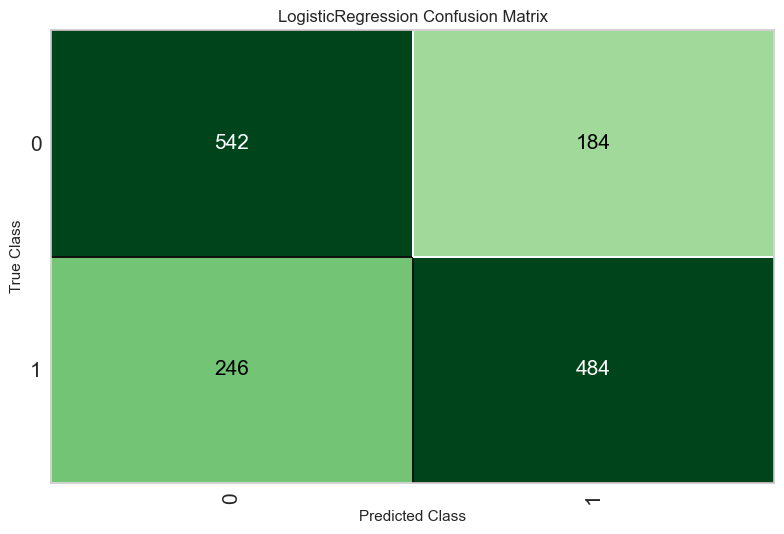

In [55]:
# plot confusion matrix
plot_model(tuned_model_tf, plot = 'confusion_matrix')

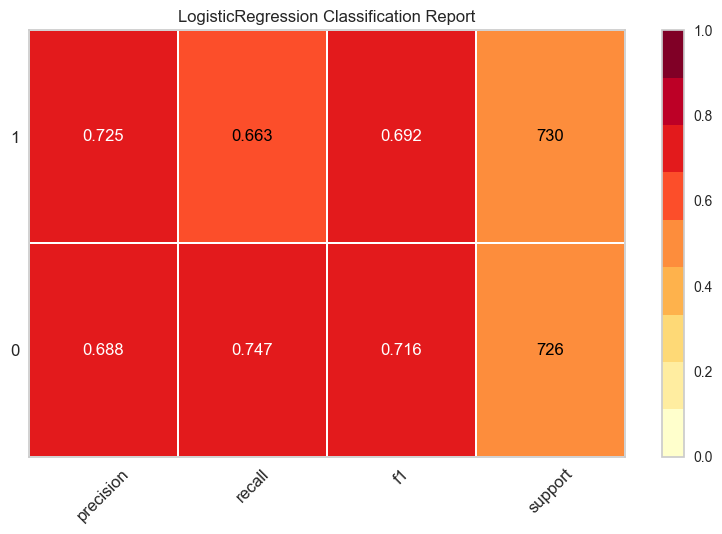

In [56]:
plot_model(tuned_model_tf, plot = 'class_report')

In [57]:
pred_holdouts_tf = predict_model(tuned_model_tf)
pred_holdouts_tf.head()

0430   09   10  10 hour  10 min  100  100 follower  106  106 flight  \
3395   0.0  0.0  0.0      0.0     0.0  0.0           0.0  0.0         0.0   
3396   0.0  0.0  0.0      0.0     0.0  0.0           0.0  0.0         0.0   
3397   0.0  0.0  0.0      0.0     0.0  0.0           0.0  0.0         0.0   
3398   0.0  0.0  0.0      0.0     0.0  0.0           0.0  0.0         0.0   
3399   0.0  0.0  0.0      0.0     0.0  0.0           0.0  0.0         0.0   

      10pm  ...  youth  youtube   yr  yuck  yum  yup  yup go  target  \
3395   0.0  ...    0.0      0.0  0.0   0.0  0.0  0.0     0.0       0   
3396   0.0  ...    0.0      0.0  0.0   0.0  0.0  0.0     0.0       0   
3397   0.0  ...    0.0      0.0  0.0   0.0  0.0  0.0     0.0       1   
3398   0.0  ...    0.0      0.0  0.0   0.0  0.0  0.0     0.0       1   
3399   0.0  ...    0.0      0.0  0.0   0.0  0.0  0.0     0.0       1   

      prediction_label  prediction_score  
3395                 1            0.5742  
3396                 0            0.6982  
3397                 0            0.7731  
3398                 1            0.6970  
3399                 0            0.7026  

[5 rows x 4386 columns]

In [58]:
# Finalize the model (train on the entire dataset)
finalize_model(tuned_model_tf)

2024/12/06 14:30:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/06 14:30:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression at: http://localhost:5000/#/experiments/374735653194037029/runs/ceb584f72b4f4327995989f0959e8144.
2024/12/06 14:30:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/374735653194037029.


Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['0430', '09', '10', '10 hour',
                                             '10 min', '100', '100 follower',
                                             '106', '106 flight', '10pm', '11',
                                             '1130', '11pm', '12', '12 crew',
                                             '12 hour', '12 week', '125',
                                             '12hour', '12hour flight', '13',
                                             '13 hour', '130', '14', '15',
                                             '15 min', '15 minute', '17',
                                             '17th', '18', ...],
                                    transformer=...
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+'))),
                ('actual_estimator',
                 LogisticRegression(C=0.472, class_weight='balanced',
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=1000, multi_class='auto',
                                    n_jobs=None, penalty='l2', random_state=123,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [62]:
import os
from datetime import datetime
from pycaret.classification import save_model

# Définir le chemin du répertoire courant
PATH = os.getcwd() + os.sep

# Créer le sous-répertoire 'models' s'il n'existe pas
models_dir = PATH + "models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Définir l'heure actuelle pour ajouter au nom du modèle
current_time = datetime.now().strftime("%m-%d-%Y_%H-%M")

# Sauvegarder le modèle dans le répertoire 'models'
save_model(tuned_model_tf, os.path.join(models_dir, "best_model_TfIdf_" + current_time))

# Charger le modèle sauvegardé
# loaded_bestmodel = load_model(os.path.join(models_dir, 'best_model_TfIdf_' + current_time))


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['0430', '09', '10', '10 hour',
                                              '10 min', '100', '100 follower',
                                              '106', '106 flight', '10pm', '11',
                                              '1130', '11pm', '12', '12 crew',
                                              '12 hour', '12 week', '125',
                                              '12hour', '12hour flight', '13',
                                              '13 hour', '130', '14', '15',
                                              '15 min', '15 minute', '17',
                                              '17th', '18', ...],
                                     transformer=...
                  TransformerWrapper(exclude=None, include=None,
                                     transformer=CleanColumnNames

In [63]:
# Générer des prédictions pour le jeu de test
predictions_tf = predict_model(tuned_model_tf, data=test_tfidf)

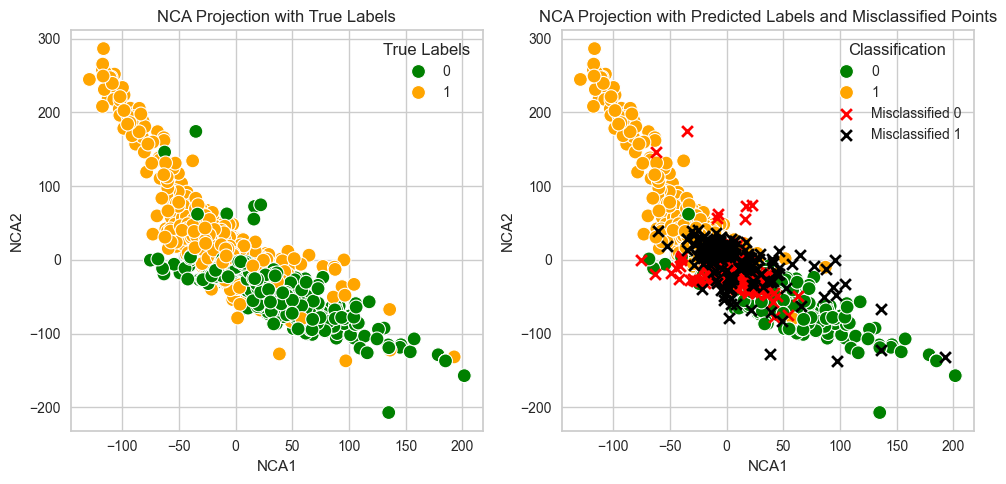


Faux Négatifs (Prédit comme 0, mais vrai label 1) :
- @emmacandlish re-reading new moon. decided im taking eclips on the plane, so i wanna read new moon before it . LOL 
- Air France 447 inbound from Brazil to Paris disappears... shit, I have controlled that flight LOTS of times... 
- Sitting in the airport, just got off the phone with Verizon to have them fix my phone! Will be home soon!!! 
- Did anyone have issues with their 360 ghostbusters flight suit code not working?  #xbox #ghostbusters
- feels bad for robert being attcked by paps in the airport. also, feels bad for watching these videos. 
- Was listening to @Eminem and @taylorswift13 on the plane 
- I'm sad @kacisloss is leaving today. I should have told her it wasn't possible to change her flight. 
- @BerlyAnne *grins* I am glad to see a smile from you this morning! Packed-n-ready to fly yet?? No rush of course, 6 a.m. flight.. 
- Thanks to the crew of EclecticRadio and Havana for the great night! Only bad thing is the tiredn

In [64]:
df = predictions_tf
visualize_nca_predictions(df, train_df)

Dans cette représentation et ce modèle la classe 0 et la classe 1 sont détectées avec le même niveau d'exactitude, par contre il n'est pas plus performant que CountVectorizer.

In [65]:
mlflow.end_run()

2024/12/06 14:38:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run Pycaret (TfIdf) at: http://localhost:5000/#/experiments/374735653194037029/runs/35dc518b01634137bc9e9effbcaf329c.
2024/12/06 14:38:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/374735653194037029.


# Autosklearn
Notebook: P7_Test_AutoSKLearn_Ubuntu_via_WSL.ipynb

Une exploration avec autosklearn depuis un embedding TfIdf a également mené à classifier basique "Passive-agressive classifier". La performance est équivalente (accuracy 0.7) à celle d'un modèle de régression logistique ou extra trees, l'intérêt est limité.

# Utilisation des solutions sur étagère de Azure
Ces outils nécessitent d'avoir un compte Azure (AutoML est payant)

## AutoML

A partir du dataframe contenant les colonnes "text" (texte brut des tweets) et "target" AutoML détermine le pré-traitement le plus adéquat <br>
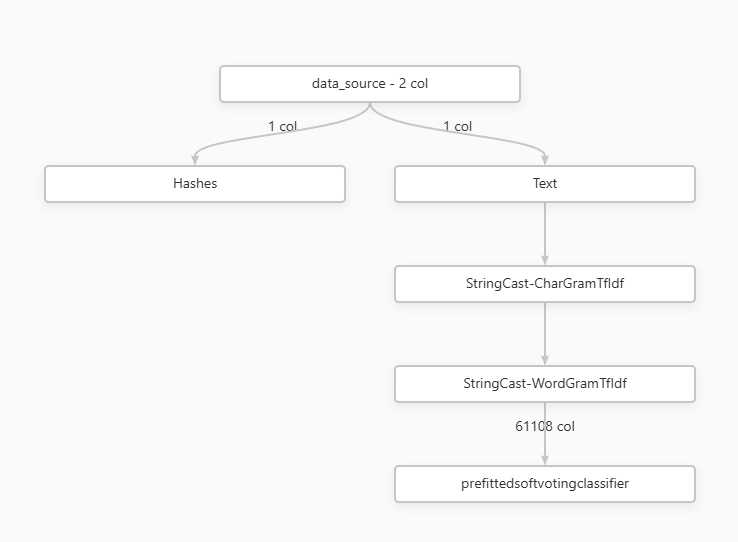
Puis teste un ensemble d'algorithmes de classification avec les performances suivantes:<br>
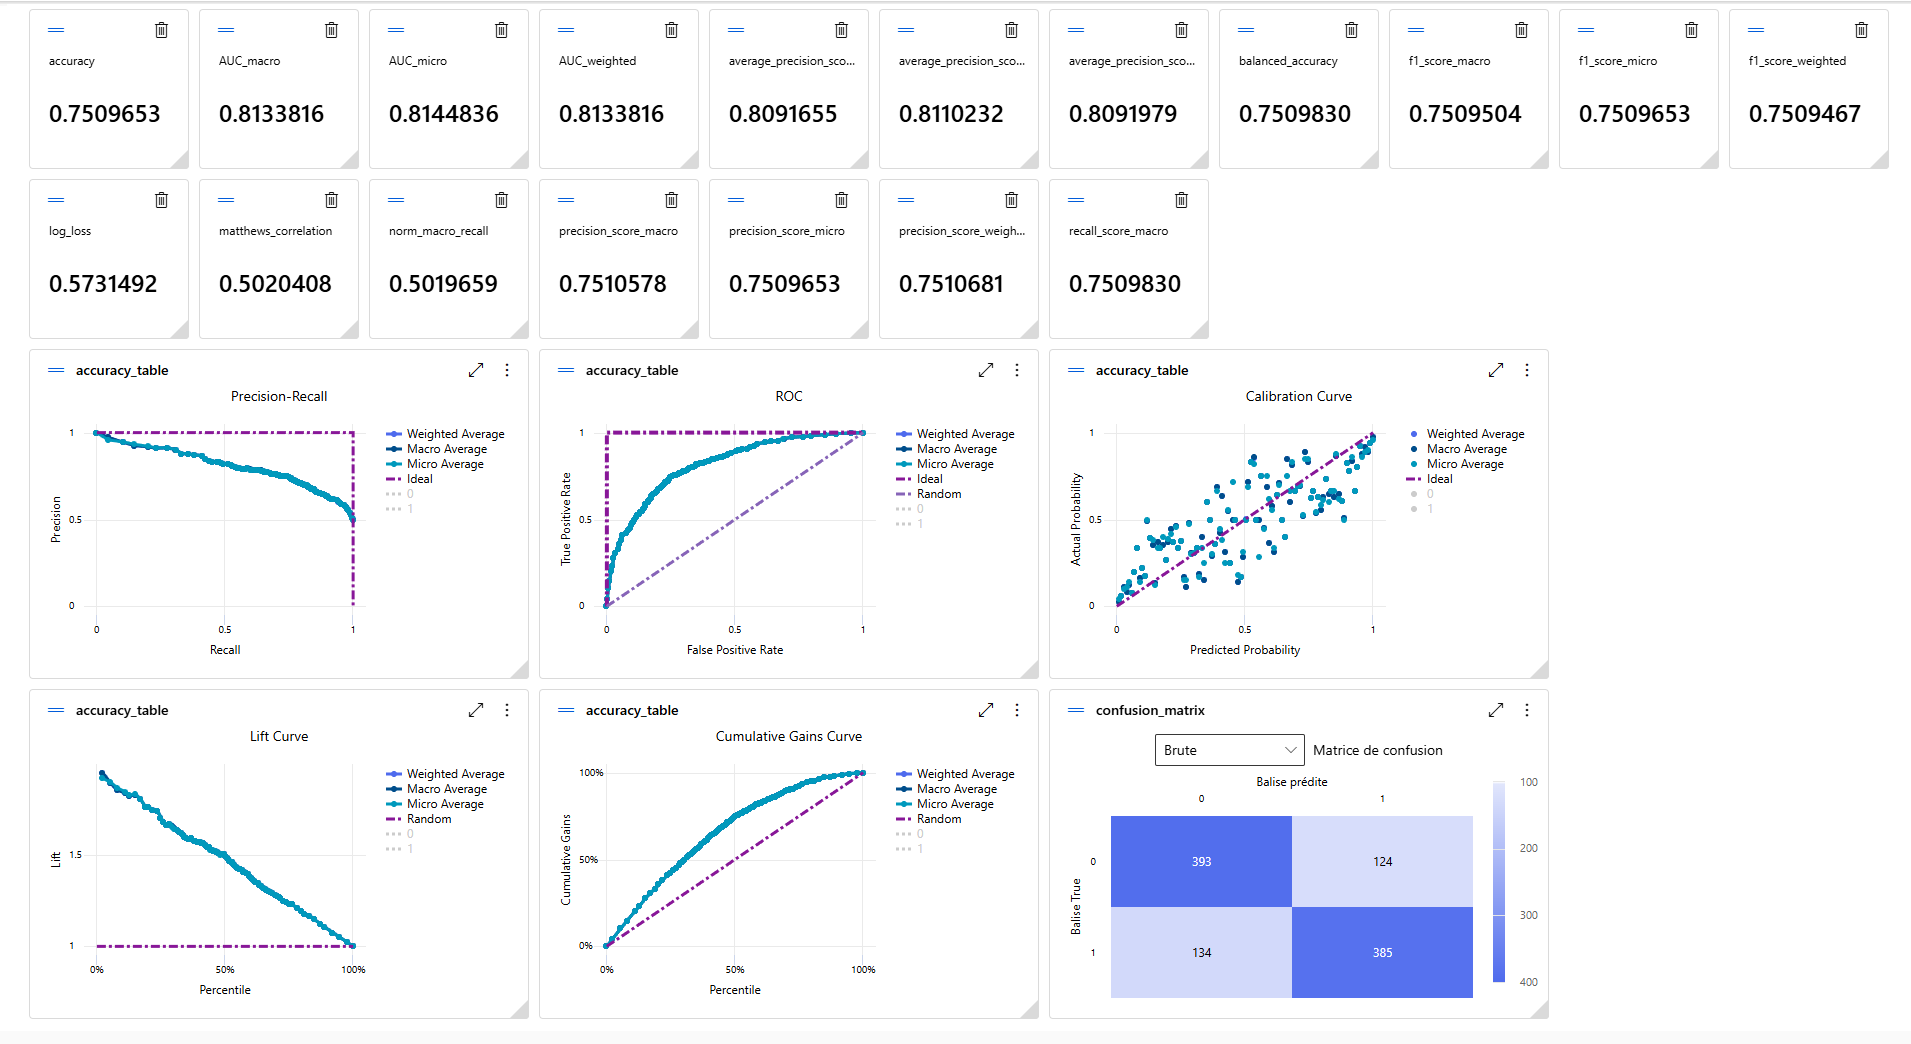<br>
Le modèle est un ensemble combinant différentes régressions logistiques et un modèle linearSVM. L'algorithme de plus grand poind a les paramètres suivants:<br>
Poids de l'ensemble: 0.23076923076923078 <br>
Prétraitement: <br>
<code>
{
    "class_name": "MaxAbsScaler",
    "module": "sklearn.preprocessing",
    "param_args": [],
    "param_kwargs": {},
    "prepared_kwargs": {},
    "spec_class": "preproc"
}
</code>
Algorithme d'entrainement <br>
<code>
{
    "class_name": "LogisticRegression",
    "module": "sklearn.linear_model",
    "param_args": [],
    "param_kwargs": {
        "C": 3237.45754281764,
        "class_weight": "balanced",
        "multi_class": "ovr",
        "penalty": "l1",
        "solver": "saga"
    },
    "prepared_kwargs": {},
    "spec_class": "sklearn"
}
</code>

Ce modèle a été téléchargé et loggé dans AutoML (nécessite Linux).<br>
Il nous apprend qu'une solution basée sur la régression logistique peut être relativement performante.

## Azure Language Analytics
Notebook: azure_language_model.ipynb

Une API d'analyse de langage est également proposée par Azure. Ce modèle repose sur des modèles NLP avec des architectures de type transformer optimisés pour comprendre un large éventail de phrases (T-NLG Turing Natural Language Generation).

Une accuracy de 0.63 nous prouve que le problème est loin d'être trivial, d'autant plus que les performances sont très différentes avec une très bonne détection de la classe positive (tweets négatifs) mais beaucoup de faux positifs. Donc un modèle alarmiste. 

# Modèle économique 
En considérant la qualité informative apportée par SentimentIntensityAnalyser de NLTK nous allons combiner cette colonne avec l'analyse par régression logistique.

## Tests de régression logistique

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

In [70]:
# Charger les DataFrames depuis les fichiers CSV
train_df = pd.read_csv('./data/train_df.csv')
val_df = pd.read_csv('./data/val_df.csv')
test_df = pd.read_csv('./data/test_df.csv')

# Séparer les features et les labels pour chaque ensemble
X_train = train_df[['text', 'sia_sentiment']]
y_train = train_df['target']
X_val = val_df[['text', 'sia_sentiment']]
y_val = val_df['target']
X_test = test_df[['text', 'sia_sentiment']]
y_test = test_df['target']

# Créer le préprocesseur pour appliquer les transformations aux colonnes respectives
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2)), 'text'),
        ('scaler', Pipeline([('standard', StandardScaler()), ('maxabs', MaxAbsScaler())]), ['sia_sentiment'])
    ]
)

# Construire le pipeline avec le préprocesseur et le modèle de régression logistique
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Entraîner le pipeline sur les données d'entraînement
pipeline.fit(X_train, y_train)

# Évaluer le pipeline sur l'ensemble de validation
y_val_pred = pipeline.predict(X_val)
print("Validation Set Performance:\n", classification_report(y_val, y_val_pred))

# Prédire et évaluer le pipeline sur l'ensemble de test final
y_test_pred = pipeline.predict(X_test)
print("Test Set Performance:\n", classification_report(y_test, y_test_pred))


Validation Set Performance:
               precision    recall  f1-score   support

           0       0.71      0.74      0.73       726
           1       0.73      0.70      0.72       730

    accuracy                           0.72      1456
   macro avg       0.72      0.72      0.72      1456
weighted avg       0.72      0.72      0.72      1456

Test Set Performance:
               precision    recall  f1-score   support

           0       0.74      0.75      0.75       807
           1       0.75      0.74      0.75       810

    accuracy                           0.75      1617
   macro avg       0.75      0.75      0.75      1617
weighted avg       0.75      0.75      0.75      1617



L'exactitude est au niveau des meilleurs résultats obtenus jusqu'ici. On peut optimiser de façon automatique par rapport à une métrique.

In [73]:
# ! pip install optuna

In [98]:
# Priorité à l'accuracy
import optuna
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Charger les DataFrames depuis les fichiers CSV
train_df = pd.read_csv('./data/train_df.csv')
val_df = pd.read_csv('./data/val_df.csv')

# Séparer les features et les labels pour chaque ensemble
X_train = train_df[['text', 'sia_sentiment']]
y_train = train_df['target']
X_val = val_df[['text', 'sia_sentiment']]
y_val = val_df['target']

# Définir la fonction d'objectif pour Optuna
def objective(trial):
    # Hyperparamètres à optimiser
    C = trial.suggest_loguniform("C", 1e-4, 1e4)  # Paramètre de régularisation
    solver_penalty = trial.suggest_categorical(
        "solver_penalty",
        [
            ("lbfgs", "l2"),
            ("liblinear", "l1"),
            ("liblinear", "l2"),
            ("saga", "l1"),
            ("saga", "l2"),
            ("saga", "elasticnet")
        ]
    )
    solver, penalty = solver_penalty
    l1_ratio = None
    if penalty == "elasticnet":
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

    # Préprocesseur : reste inchangé
    preprocessor = ColumnTransformer(
        transformers=[
            ('tfidf', TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2)), 'text'),
            ('scaler', Pipeline([('standard', StandardScaler()), ('maxabs', MaxAbsScaler())]), ['sia_sentiment'])
        ]
    )
    
    # Pipeline avec la régression logistique
    classifier = LogisticRegression(
        C=C, solver=solver, penalty=penalty, l1_ratio=l1_ratio, max_iter=200, random_state=42
    )
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    # Entraîner le pipeline
    pipeline.fit(X_train, y_train)
    
    # Évaluer les performances sur l'ensemble de validation
    y_val_pred = pipeline.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    return accuracy

# Créer l’étude Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Résultats
print("Best hyperparameters:", study.best_params)
print("Best validation accuracy:", study.best_value)

[I 2024-12-07 10:31:54,697] A new study created in memory with name: no-name-3e0aed75-acfe-4a69-b0e2-aea23cc5dacb
[I 2024-12-07 10:31:54,889] Trial 0 finished with value: 0.7060439560439561 and parameters: {'C': 48.3065114957649, 'solver_penalty': ('liblinear', 'l1')}. Best is trial 0 with value: 0.7060439560439561.
[I 2024-12-07 10:32:04,424] Trial 1 finished with value: 0.7108516483516484 and parameters: {'C': 200.56080735948737, 'solver_penalty': ('saga', 'l1')}. Best is trial 1 with value: 0.7108516483516484.
[I 2024-12-07 10:32:04,718] Trial 2 finished with value: 0.7067307692307693 and parameters: {'C': 637.8301427026097, 'solver_penalty': ('saga', 'l2')}. Best is trial 1 with value: 0.7108516483516484.
[I 2024-12-07 10:32:04,859] Trial 3 finished with value: 0.49862637362637363 and parameters: {'C': 0.0001027609324678321, 'solver_penalty': ('liblinear', 'l1')}. Best is trial 1 with value: 0.7108516483516484.
[I 2024-12-07 10:32:04,992] Trial 4 finished with value: 0.642857142857

Best hyperparameters: {'C': 7.9564999785275266, 'solver_penalty': ('liblinear', 'l2')}
Best validation accuracy: 0.7328296703296703


In [97]:
# # Alternative priorité au recall ATTENTION la recherche OPTUNA peut dériver vers DUMMY (cf. Pycaret)

# from sklearn.metrics import recall_score

# # Définir la fonction d'objectif pour Optuna avec le recall comme métrique
# def objective(trial):
#     # Hyperparamètres à optimiser
#     C = trial.suggest_loguniform("C", 1e-4, 1e4)  # Paramètre de régularisation
#     solver_penalty = trial.suggest_categorical(
#         "solver_penalty",
#         [
#             ("lbfgs", "l2"),
#             ("liblinear", "l1"),
#             ("liblinear", "l2"),
#             ("saga", "l1"),
#             ("saga", "l2"),
#             ("saga", "elasticnet")
#         ]
#     )
#     solver, penalty = solver_penalty
#     l1_ratio = None
#     if penalty == "elasticnet":
#         l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

#     # Préprocesseur : reste inchangé
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('tfidf', TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2)), 'text'),
#             ('scaler', Pipeline([('standard', StandardScaler()), ('maxabs', MaxAbsScaler())]), ['sia_sentiment'])
#         ]
#     )
    
#     # Pipeline avec la régression logistique
#     classifier = LogisticRegression(
#         C=C, solver=solver, penalty=penalty, l1_ratio=l1_ratio, max_iter=200, random_state=42
#     )
#     pipeline = Pipeline([
#         ('preprocessor', preprocessor),
#         ('classifier', classifier)
#     ])
    
#     # Entraîner le pipeline
#     pipeline.fit(X_train, y_train)
    
#     # Évaluer les performances sur l'ensemble de validation
#     y_val_pred = pipeline.predict(X_val)
#     recall = recall_score(y_val, y_val_pred, average='binary')  # 'binary' pour les problèmes binaires
#     return recall

# # Créer l’étude Optuna
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)

# # Résultats
# print("Best hyperparameters:", study.best_params)
# print("Best validation recall:", study.best_value)


[I 2024-12-07 10:30:18,798] A new study created in memory with name: no-name-cab3b0d7-ad64-48a9-b632-7cf02fb6d2d7
[I 2024-12-07 10:30:18,936] Trial 0 finished with value: 0.7109589041095891 and parameters: {'C': 0.009571104218172161, 'solver_penalty': ('liblinear', 'l2')}. Best is trial 0 with value: 0.7109589041095891.
[I 2024-12-07 10:30:19,085] Trial 1 finished with value: 0.7150684931506849 and parameters: {'C': 0.06415273246000311, 'solver_penalty': ('saga', 'l2')}. Best is trial 1 with value: 0.7150684931506849.
[I 2024-12-07 10:30:19,213] Trial 2 finished with value: 0.7109589041095891 and parameters: {'C': 0.028039727193782542, 'solver_penalty': ('lbfgs', 'l2')}. Best is trial 1 with value: 0.7150684931506849.
[I 2024-12-07 10:30:19,351] Trial 3 finished with value: 0.6726027397260274 and parameters: {'C': 2020.0322961341367, 'solver_penalty': ('liblinear', 'l1')}. Best is trial 1 with value: 0.7150684931506849.
[I 2024-12-07 10:30:23,683] Trial 4 finished with value: 0.6821917

Best hyperparameters: {'C': 0.0024687139974742802, 'solver_penalty': ('saga', 'l1')}
Best validation recall: 1.0


Test Set Performance:
               precision    recall  f1-score   support

           0       0.73      0.75      0.74       807
           1       0.74      0.72      0.73       810

    accuracy                           0.74      1617
   macro avg       0.74      0.74      0.74      1617
weighted avg       0.74      0.74      0.74      1617



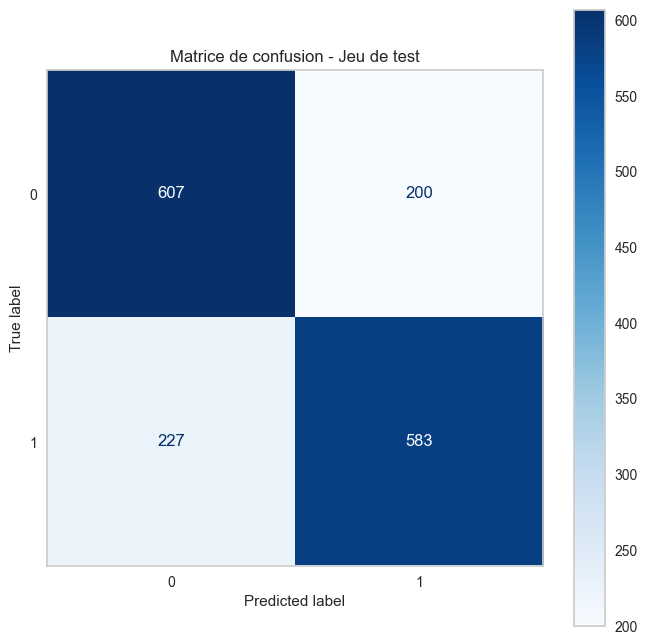

In [101]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Charger les DataFrames depuis les fichiers CSV
train_df = pd.read_csv('./data/train_df.csv')
val_df = pd.read_csv('./data/val_df.csv')
test_df = pd.read_csv('./data/test_df.csv')

# Séparer les features et les labels pour chaque ensemble
X_train = train_df[['text', 'sia_sentiment']]
y_train = train_df['target']
X_test = test_df[['text', 'sia_sentiment']]
y_test = test_df['target']

# Meilleurs paramètres obtenus via Optuna
best_params = study.best_params  # Charger les paramètres depuis Optuna

# Extraction des paramètres spécifiques
C = best_params['C']
solver_penalty = best_params['solver_penalty']
solver, penalty = solver_penalty
l1_ratio = best_params.get('l1_ratio', None)  # Peut être None si non utilisé

# Créer le préprocesseur pour les transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2)), 'text'),
        ('scaler', Pipeline([('standard', StandardScaler()), ('maxabs', MaxAbsScaler())]), ['sia_sentiment'])
    ]
)

# Construire le pipeline avec les meilleurs paramètres
classifier = LogisticRegression(
    C=C,
    solver=solver,
    penalty=penalty,
    l1_ratio=l1_ratio,
    max_iter=200,  # ou autre valeur selon votre configuration
    random_state=42
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Entraîner le pipeline sur les données d'entraînement
pipeline.fit(X_train, y_train)

# Prédire sur le jeu de test
y_test_pred = pipeline.predict(X_test)

# Afficher les performances
print("Test Set Performance:\n", classification_report(y_test, y_test_pred))

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_test_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=pipeline.classes_)
fig, ax = plt.subplots(figsize=(8, 8))  # Taille personnalisée pour plus de lisibilité
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.grid(False)  # Désactiver la grille intérieure
plt.title("Matrice de confusion - Jeu de test")
plt.show()


L'optimisation n'a pas amené d'amélioration par rapport à une régression logistique simple.<br>
<b>Pistes pour des améliorations futures:<br></b>
L'optimisation s'arrête ici. L'exactitude du modèle est très honorable pour des moyens de calcul aussi modestes. Il pourrait être intéressant de travailler le features engineering (utilisation d'autres colonnes comme la longueur des tweets, introduction de termes quadratiques etc...).<br>
Un algorithme plus élaboré serait peut être plus susceptible d'être amélioré par ajustement des paramètres (RandomForest, GBC).

## Sauvegarde du modèle dans MLFlow

In [114]:
import time
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score
import mlflow
import mlflow.sklearn
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn import set_config
from mlflow.models.signature import infer_signature
import matplotlib.pyplot as plt
import seaborn as sns

# Initialiser Sentiment Intensity Analyzer de NLTK
sia = SentimentIntensityAnalyzer()

# Fonction pour ajouter sia_sentiment dans le pipeline
def compute_sia_sentiment(texts):
    return [[sia.polarity_scores(text)['compound']] for text in texts]

# Charger les DataFrames depuis les fichiers CSV
train_df = pd.read_csv('./data/train_df.csv')
val_df = pd.read_csv('./data/val_df.csv')
test_df = pd.read_csv('./data/test_df.csv')

# Séparer les features et les labels et transformer les features en DataFrames
X_train, y_train = train_df[['text']], train_df['target']
X_val, y_val = val_df[['text']], val_df['target']
X_test, y_test = test_df[['text']], test_df['target']

# Configurer MLflow et commencer un run
mlflow.start_run(run_name="pipeline_lr")

# Créer le préprocesseur pour le pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2)), 'text'),
        ('sia_sentiment', Pipeline([
            ('compute_sia', FunctionTransformer(compute_sia_sentiment, validate=False)),
            ('scaler', StandardScaler())
        ]), 'text')
    ]
)

# Créer le pipeline complet avec le préprocesseur
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=200, random_state=42))
])

# Mesurer le temps d'entraînement
start_time = time.time()
pipeline.fit(X_train, y_train)
training_time = time.time() - start_time

# Prédictions et évaluation sur le set de validation
y_val_pred = pipeline.predict(X_val)
val_report = classification_report(y_val, y_val_pred, output_dict=True)
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

# Prédictions et évaluation sur le set de test
y_test_pred = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred, pos_label=1)  # Classe positive
test_report = classification_report(y_test, y_test_pred, output_dict=True)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Log du modèle dans MLflow
mlflow.sklearn.log_model(
    pipeline, "model",
    signature=infer_signature(X_train, y_train),
    input_example=X_train.head(5)
)

# Logger les métriques principales
mlflow.log_metrics({
    "TT": training_time,               # Temps d'entraînement
    "Accuracy": test_accuracy,         # Accuracy pour comparaison PyCaret
    "Recall": test_recall,             # Recall pour comparaison PyCaret
    "val_accuracy": val_report['accuracy'],
    "val_f1": val_report['weighted avg']['f1-score'],
    "test_f1": test_report['weighted avg']['f1-score']
})

# Log du rapport de classification et de la matrice de confusion sous forme d'artefacts
def log_conf_matrix(cm, labels, name):
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    plt.title(f"Confusion Matrix - {name}")
    mlflow.log_figure(fig, f"{name}_confusion_matrix.png")
    plt.close(fig)

# Log des matrices de confusion pour validation et test
log_conf_matrix(val_conf_matrix, labels=['negative', 'positive'], name="Validation")
log_conf_matrix(test_conf_matrix, labels=['negative', 'positive'], name="Test")

### Validation du serving payload

In [115]:
import mlflow
from mlflow.models import validate_serving_input
from mlflow.models.signature import infer_signature
import json

# Le serving payload sous forme de chaîne JSON
serving_payload = """{
  "dataframe_split": {
    "columns": [
      "text"
    ],
    "data": [
      [
        "more bodies found from air france flight. now its at 5 "
      ],
      [
        "@ChrisTFT yes it is insaaannnee over there! @ least that's what i'm told.  have a safe flight"
      ],
      [
        "@ebassman Dang! Wish I was there! Hop a flight to chattanooga! "
      ],
      [
        "Off to the airport for Maria's album launch "
      ],
      [
        "@iamsmartalek Man, that is such a bummer to hear.  I never even did the last software upgrade in anticipation of this one.  "
      ]
    ]
  }
}"""

# Parse the payload to a JSON object
serving_payload_json = json.loads(serving_payload)

# Enregistrer l'URI du run actif
active_run = mlflow.active_run()
if active_run:
    model_uri = f"runs:/{active_run.info.run_id}/model"
    # Valider l'entrée de service pour le modèle sans créer un nouveau run
    validate_serving_input(model_uri, serving_payload_json)

    # Compléter le run en cours en ajoutant le modèle et les autres informations
    mlflow.sklearn.log_model(pipeline, "model", signature=infer_signature(X_train, y_train), input_example=X_train.head(5))
    
    # Log des métriques ou autres informations nécessaires dans ce run actif
    # Exemple: mlflow.log_metrics({"example_metric": value})


In [117]:
mlflow.end_run()

2024/12/07 11:52:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run pipeline_lr at: http://localhost:5000/#/experiments/374735653194037029/runs/bd5029bd0143409fa7a3fa5a1b392e5f.
2024/12/07 11:52:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/374735653194037029.


In [116]:
model_uri

'runs:/bd5029bd0143409fa7a3fa5a1b392e5f/model'

In [118]:
import mlflow
import pandas as pd

# Échantillonner 1 ligne aléatoire de la colonne "text" de test_df
data = test_df[['text']].sample(1).reset_index(drop=True)

# Afficher la phrase
print("Phrase : ", data['text'].values[0])

# Charger le modèle enregistré
# model_uri défini précédemment
model = mlflow.pyfunc.load_model(model_uri)

# Effectuer la prédiction sur la phrase
# Envoie un DataFrame avec la colonne 'text'
prediction = model.predict(data)

# Afficher le sentiment
if prediction[0] == 0:
    print("Sentiment : positif")
else:
    print("Sentiment : négatif")


Phrase :  Boarding the Shanghai flight. Sad to leave Beijing 


Sentiment : négatif


In [119]:
import mlflow
import pandas as pd

# Exemple d'entrée sous forme de chaîne
sentence = "My baggage was damaged and the airline took no responsibility for it."

# Créer un DataFrame avec la phrase
data = pd.DataFrame({'text': [sentence]})

# Afficher la phrase
print("Phrase : ", sentence)

# Modèle déja chargé

# Effectuer la prédiction sur la phrase
prediction = model.predict(data)

# Afficher le sentiment
if prediction[0] == 0:
    print("Sentiment : positif")
else:
    print("Sentiment : négatif")


Phrase :  My baggage was damaged and the airline took no responsibility for it.
Sentiment : négatif


### Enregistrement du modèle loggé

In [120]:
# Enregistrer le modèle dans le Model Registry local
import mlflow

# Nom du modèle dans le Model Registry
model_name = "Pipeline_sia_lr"

# Enregistrement du modèle chargé dans le registre sous le nom spécifié
model_version = mlflow.register_model(model_uri=model_uri, name=model_name)

# Ajout de l'alias "champion" à la dernière version du modèle
client = mlflow.tracking.MlflowClient()
client.set_registered_model_alias(name=model_name, alias="champion_eco", version=model_version.version)

print(f"Modèle enregistré avec succès sous le nom '{model_name}' avec l'alias 'champion_eco'.")

Successfully registered model 'Pipeline_sia_lr'.
2024/12/07 12:00:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Pipeline_sia_lr, version 1


Modèle enregistré avec succès sous le nom 'Pipeline_sia_lr' avec l'alias 'champion_eco'.


Created version '1' of model 'Pipeline_sia_lr'.


### Sauvegarde du modèle sur Azure Blob

In [121]:
import mlflow
import os
import shutil

# URI du modèle dans le Model Registry
model_name = "Pipeline_sia_lr"
model_version = "1"
model_uri = f"models:/{model_name}/{model_version}"

# Répertoire local pour enregistrer le modèle
model_dir = "./model_temp"  # Répertoire temporaire

# Supprimer le répertoire s'il existe déjà
if os.path.exists(model_dir):
    shutil.rmtree(model_dir)

# Télécharger le modèle depuis MLflow
mlflow.artifacts.download_artifacts(artifact_uri=model_uri, dst_path=model_dir)

print(f"Modèle téléchargé en local sous {model_dir}")


Modèle téléchargé en local sous ./model_temp


In [123]:
# ! pip install azure-storage-blob

from azure.storage.blob import BlobServiceClient
import os
import shutil

# Chaîne de connexion Azure Storage
storage_connection_string = os.environ.get("AZURE_STORAGE_CONNECTION_STRING")
container_name = "oc-p7-ecomodele"

# Initialiser le client de service Blob
blob_service_client = BlobServiceClient.from_connection_string(storage_connection_string)

# Chemin du répertoire contenant le modèle
local_model_path = model_dir

# Upload des fichiers du modèle
for root, dirs, files in os.walk(local_model_path):
    for file_name in files:
        # Chemin local du fichier
        file_path = os.path.join(root, file_name)

        # Chemin dans le container Azure Blob
        blob_name = os.path.relpath(file_path, local_model_path)
        blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)

        # Upload du fichier
        with open(file_path, "rb") as data:
            blob_client.upload_blob(data, overwrite=True)

print(f"Modèle uploadé dans le container Azure Blob '{container_name}'.")

# Suppression du dossier local après l'upload
try:
    # Vérifie si le dossier existe
    if os.path.exists(local_model_path) and os.path.isdir(local_model_path):
        # Suppression récursive du répertoire et de son contenu
        shutil.rmtree(local_model_path)
        print(f"Dossier local '{local_model_path}' supprimé.")
    else:
        print(f"Le dossier local '{local_model_path}' n'existe pas.")
except Exception as e:
    print(f"Erreur lors de la suppression du dossier local : {e}")


Modèle uploadé dans le container Azure Blob 'oc-p7-ecomodele'.
Dossier local './model_temp' supprimé.


## Test de fonctionnement local du meilleur modèle classique

In [ ]:
# !pip install deep-translator 

In [2]:
# Test initial: run avec le modèle disponible localement
%run deploiement_local_flask_eco.py # 

 * Serving Flask app 'deploiement_local_flask_eco'
 * Debug mode: off


 * Running on http://127.0.0.1:5001
Press CTRL+C to quit
127.0.0.1 - - [07/Dec/2024 21:15:09] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2024 21:15:13] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2024 21:15:16] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2024 21:15:20] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2024 21:15:24] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2024 21:15:34] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2024 21:15:47] "POST / HTTP/1.1" 200 -


In [138]:
# run avec le modèle téléchargé depuis le blobstorage (le script télécharge localement le modèle)
%run deploiement_local_flask_eco_modeleAzure.py 

Téléchargé : MLmodel
Téléchargé : conda.yaml
Téléchargé : input_example.json
Téléchargé : model.pkl
Téléchargé : python_env.yaml
Téléchargé : registered_model_meta
Téléchargé : requirements.txt
Téléchargé : serving_input_example.json
Modèle chargé avec succès.
 * Serving Flask app 'deploiement_local_flask_eco_modeleAzure'
 * Debug mode: off


 * Running on http://127.0.0.1:5001
Press CTRL+C to quit


In [1]:
# version finale du script dans le dossier de test
# import os # Assigner la variable d'environnement pour le mode test
os.environ['FLASK_ENV'] = "production"
%run "C:\\Users\\cecil\\Documents\\p7_app_test\\app.py" 

## Interrogation de l'API

In [2]:
import requests

url = "https://tweetseco-aqb3breuc4f6bsaj.francecentral-01.azurewebsites.net"
response = requests.get(url)

if response.status_code == 200:
    print("Réponse de l'API :")
    print(response)
else:
    print(f"Erreur {response.status_code}: {response.text}")

Réponse de l'API :
<Response [200]>


In [3]:
import requests

# URL de l'endpoint /predict
url = "https://tweetseco-aqb3breuc4f6bsaj.francecentral-01.azurewebsites.net/predict"

# Liste des textes à analyser
texts = [
    "I love programming!", 
    "Today is such a bad day.", 
    "The weather is amazing.", 
    "I'm feeling really sad right now.", 
    "This is the best thing ever!"
]

# Stocker les résultats
predictions = []

# Boucle sur chaque texte
for text in texts:
    # Construire le payload JSON
    payload = {"text": text}
    
    try:
        # Envoyer la requête POST
        response = requests.post(url, json=payload)
        
        # Vérifier le statut de la réponse
        if response.status_code == 200:
            result = response.json()
            predictions.append({
                "text": text,
                "prediction": result.get("prediction"),
                "translated_text": result.get("translated_text", "N/A")  # Si la traduction est incluse
            })
        else:
            predictions.append({
                "text": text,
                "error": f"Erreur {response.status_code}: {response.text}"
            })
    except Exception as e:
        predictions.append({
            "text": text,
            "error": f"Exception: {str(e)}"
        })

# Afficher les résultats
for pred in predictions:
    print(f"Texte: {pred['text']}")
    if "prediction" in pred:
        print(f"  - Prédiction : {pred['prediction']}")
        print(f"  - Texte traduit : {pred['translated_text']}")
    else:
        print(f"  - Erreur : {pred['error']}")


Texte: I love programming!
  - Prédiction : [0]
  - Texte traduit : I love programming!
Texte: Today is such a bad day.
  - Prédiction : [1]
  - Texte traduit : Today is such a bad day.
Texte: The weather is amazing.
  - Prédiction : [0]
  - Texte traduit : The weather is amazing.
Texte: I'm feeling really sad right now.
  - Prédiction : [1]
  - Texte traduit : I'm feeling really sad right now.
Texte: This is the best thing ever!
  - Prédiction : [0]
  - Texte traduit : This is the best thing ever!


## Amélioration continue
Récupération des insights depuis Azure si on a une accumulation sur une durée déterminée on ré-entraine le modèle.

In [17]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# Remplacez par vos propres valeurs
APP_ID = "be803281-fd4b-46ce-98cd-becf27978e7f"  # ID de l'application Application Insights
API_KEY = "yn6jwh0q3psjm43px8y6xgots6cyrjusftkd41f8"  # Clé d'API générée dans Azure

# URL de l'API
BASE_URL = f"https://api.applicationinsights.io/v1/apps/{APP_ID}/query"

# Requête KQL
KQL_QUERY = """
union isfuzzy=true
    availabilityResults,
    requests,
    exceptions,
    pageViews,
    traces,
    customEvents,
    dependencies
| where timestamp > ago(30d)
| where * has "IncorrectPrediction"
| project 
    timestamp, 
    name, 
    translated_text = tostring(customDimensions.translated_text),
    sentiment = tostring(customDimensions.sentiment),
    correct_sentiment = case(
                        tostring(customDimensions.sentiment) == "Positif",
                        1, 
                        tostring(customDimensions.sentiment) == "Négatif",
                        0, 
                        -1
                    )  // -1 pour gérer les valeurs non définies ou autres cas
| order by timestamp desc
| take 1000
"""

# Période de temps pour les données (les 7 derniers jours, par exemple - si nécessaire il y a un filtre timestamp KQL)
start_time = (datetime.utcnow() - timedelta(days=7)).strftime('%Y-%m-%dT%H:%M:%SZ')
end_time = datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%SZ')

# Corps de la requête
params = {
    "query": KQL_QUERY,
    "timespan": f"{start_time}/{end_time}"
}

# En-têtes de la requête
headers = {
    "x-api-key": API_KEY
}

# Envoyer la requête
response = requests.get(BASE_URL, headers=headers, params=params)

# Vérifier la réponse
if response.status_code == 200:
    data = response.json()
    # Extraire les résultats sous forme de DataFrame
    results = pd.DataFrame(data.get("tables", [])[0].get("rows", []), 
                           columns=[col["name"] for col in data["tables"][0]["columns"]])
    display(results)
else:
    print(f"Erreur {response.status_code}: {response.text}")


timestamp                 name  \
0   2024-11-27T20:11:35.748936Z  IncorrectPrediction   
1   2024-11-27T20:11:35.748936Z  IncorrectPrediction   
2   2024-11-27T20:11:35.748936Z  IncorrectPrediction   
3   2024-11-27T20:11:35.748936Z  IncorrectPrediction   
4   2024-11-27T20:11:35.748936Z  IncorrectPrediction   
..                          ...                  ...   
82  2024-11-25T09:14:03.472753Z  IncorrectPrediction   
83  2024-11-25T09:13:59.168979Z  IncorrectPrediction   
84  2024-11-25T09:13:55.334365Z  IncorrectPrediction   
85  2024-11-25T09:13:51.055121Z  IncorrectPrediction   
86  2024-11-25T09:11:02.796149Z  IncorrectPrediction   

                                      translated_text sentiment  \
0                          I loved flying with luxair   Positif   
1                          I loved flying with luxair   Positif   
2                          I loved flying with luxair   Positif   
3                          I loved flying with luxair   Positif   
4                          I loved flying with luxair   Positif   
..                                                ...       ...   
82  Can’t believe the food on this flight! <i>Deli...   Négatif   
83  Flight was delayed for hours and there was zer...   Négatif   
84                         I loved flying with luxair   Positif   
85                         I loved flying with luxair   Positif   
86  My flight with @AirlineName was delayed by hou...   Négatif   

    correct_sentiment  
0                   1  
1                   1  
2                   1  
3                   1  
4                   1  
..                ...  
82                  0  
83                  0  
84                  1  
85                  1  
86                  0  

[87 rows x 5 columns]

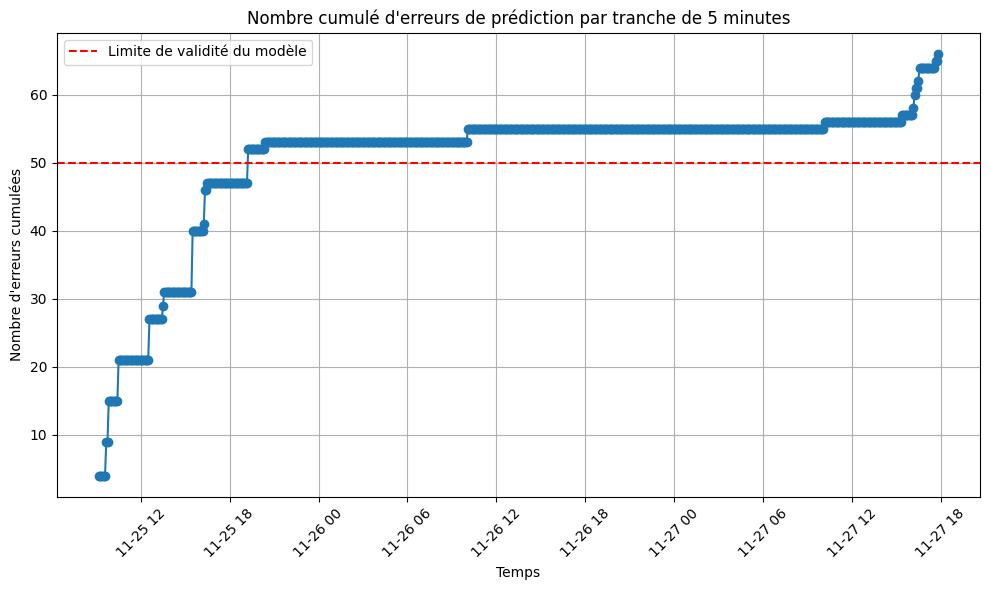

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Assurez-vous que le champ 'timestamp' est au format datetime
results['timestamp'] = pd.to_datetime(results['timestamp'])

# Filtrer les prédictions incorrectes (correct_sentiment == 0)
incorrect_predictions = results[results['correct_sentiment'] == 0]

# Créer des tranches de 5 minutes
incorrect_predictions.set_index('timestamp', inplace=True)
incorrect_predictions_resampled = incorrect_predictions.resample('5min').size().cumsum()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(incorrect_predictions_resampled.index, incorrect_predictions_resampled.values, marker='o')

# Ajouter une ligne horizontale à 50
plt.axhline(y=50, color='red', linestyle='--', label='Limite de validité du modèle')

# Titre et labels
plt.title('Nombre cumulé d\'erreurs de prédiction par tranche de 5 minutes')
plt.xlabel('Temps')
plt.ylabel('Nombre d\'erreurs cumulées')

# Affichage de la légende
plt.legend()

# Formatage du graphique
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
import os
from datetime import datetime

# Chemin vers le fichier notebook
notebook_path = "P7_approche_classique.ipynb"  

# Obtenir la dernière date de modification
last_saved = datetime.fromtimestamp(os.path.getmtime(notebook_path))
print(f"La dernière sauvegarde du notebook est : {last_saved}")



La dernière sauvegarde du notebook est : 2024-12-15 12:40:01.975348
